# Bayessian Optimization
With the concept of Gaussian process regression adressed in the previous notebooks, we shall now dive deeper to more advanced applications of GP, that is Bayessian Optimization (BO). The idea behind BO can be described as "creating a surrogate function that repersents a series of observations, and perform optimization on it". It's quite clear at this point that GP can be used as a surrogate function generator and all we need is a way to optimize it. Optimizing a differentiable acquisition function is one of the stratagies.

## Acquisition Function
An acquisition function tells where to make the next observation by leveraging between exploration and exploitation. For this notebook, we will use the **Expected Improvement** (EI) as an example:    
$$\begin{equation}
\mathrm{EI} (\boldsymbol{\mathrm{x}};\mu_\ast, \sigma_\ast, \mu_{max}, \zeta) =
    \begin{cases}
        \left(\mu_\ast\left(\boldsymbol{\mathrm{x}}\right)-\mu_{max}-\zeta\right)\Phi\left(\frac{\mu_\ast\left(\boldsymbol{\mathrm{x}}\right)-\mu_{max}-\zeta}{\sigma_\ast\left(\boldsymbol{\mathrm{x}}\right)}\right)+\sigma_\ast\left(\boldsymbol{\mathrm{x}}\right)\phi\left(\frac{\mu_\ast\left(\boldsymbol{\mathrm{x}}\right)-\mu_{max}-\zeta}{\sigma_\ast\left(\boldsymbol{\mathrm{x}}\right)}\right) & \text{if } \sigma_\ast\left(\boldsymbol{\mathrm{x}}\right)\ >\ 0\\
        0 & \text{if } \sigma_\ast\left(\boldsymbol{\mathrm{x}}\right)\ =\ 0
    \end{cases}
\end{equation},$$    
where $\mu_{max}$ represents the maximum of $\mu_\ast(\cdot)$ evaluated on the set of already made observations, $\Phi(\cdot)$ and $\phi(\cdot)$ represents CDF and PDF of the standard Gaussian distribution, and $\zeta$ is a tunable trade-off parameter. It is apperant that EI is easier to evaluate and its gradient. Thus we will be using the DIRECT algorithm complemented with gradient descent to find the maximums.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tqdm import tqdm

In [2]:
class GaussianProcess:
    def __init__(self, input_dim, kernel, mean_function=lambda x: np.zeros(x.shape[0]), noise_var=0):
        self.kernel = kernel
        self.dim = input_dim
        self.mean_function = mean_function
        self.noise_var = noise_var
        self.mean = None
        self.cov = None
        self.X = None
        self.Y = None
        
        try:
            kernel(tf.Variable([[1.,1.], [2.,2.]]), tf.Variable([[2.,2.], [1.,1.]]))
        except:
            raise RuntimeError("Invalid Mercer kernel")
        try:
            mean_function(tf.Variable([[1.,1.], [2.,2.]]))
        except:
            raise RuntimeError("Invalid mean function")
    
    
    def fit(self, X, Y):
        self.X, self.Y = X, Y
        self.cov = []
        for i in range(X.shape[0]):
            x1 = np.repeat(np.expand_dims(X[i], axis=0), X.shape[0], axis=0)
            self.cov.append(self.kernel(x1, X))
        self.cov = np.array(self.cov) + np.identity(len(self.cov)) * self.noise_var
        self.mean = self.mean_function(X)
        
    def predict(self, x):
        test_mean = self.mean_function(np.expand_dims(x, axis=0))
        x1 = np.repeat(np.expand_dims(x, axis=0), self.X.shape[0], axis=0)
        cov_train2test = self.kernel(x1, self.X)
        cov_test2test = self.kernel(x, x)
        
        predicted_mean = test_mean + tf.tensordot(cov_train2test, tf.linalg.matvec(tf.linalg.inv(self.cov), (self.Y-self.mean)), 1)
        predicted_var = cov_test2test - tf.tensordot(cov_train2test, tf.linalg.matvec(tf.linalg.inv(self.cov), cov_train2test), 1)
        return predicted_mean, predicted_var

In [102]:
rbf = lambda x1, x2, l: tf.math.exp(-tf.norm(x1-x2, axis=-1)**2 / (2*l**2))
r2 = lambda x1, x2, theta: tf.math.reduce_sum((x1 - x2)**2 / theta**2, axis=-1)
m52 = lambda x1, x2, sigma, theta: sigma**2 * (1 + tf.math.sqrt(5*r2(x1, x2, theta)) + 5/3 * r2(x1, x2, theta)) * tf.math.exp(-tf.math.sqrt(5*r2(x1, x2, theta)))
kernel = lambda x1, x2: m52(x1, x2, 2, 0.5)
model = GaussianProcess(1, kernel=kernel, noise_var=0.02)

In [103]:
function2predict = lambda x: np.sin(np.cos(0.6*x**2) + 1.5*x)

train_data_res = 5
x_train = np.expand_dims(np.linspace(-3, 3, train_data_res), axis=1)
y_train = np.reshape(function2predict(x_train), -1) + np.random.normal(0, 0.02, train_data_res)

In [104]:
model.fit(x_train, y_train)

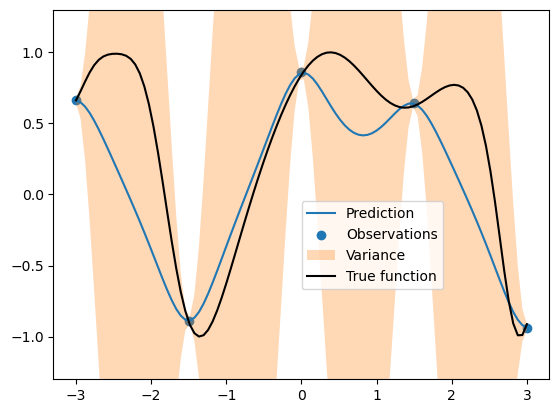

In [105]:
x_test = np.expand_dims(np.linspace(-3, 3, 100), axis=1)
y_test = []
y_var = []
for x in x_test:
    mean, var = model.predict(x)
    y_test.append(float(mean))
    y_var.append(float(var))
    
plt.plot(np.reshape(x_test, -1), y_test)
plt.scatter(np.reshape(x_train, -1), y_train)
plt.fill_between(np.reshape(x_test, -1), np.array(y_test)+np.array(y_var), np.array(y_test)-np.array(y_var), alpha=0.3)
plt.plot(np.linspace(-3, 3, 100), function2predict(np.linspace(-3, 3, 100)), c='black')
plt.ylim(-1.3, 1.3)
plt.legend(['Prediction', 'Observations', 'Variance', 'True function'], bbox_to_anchor =(0.80, 0.5), ncol = 1) 
plt.show()

### Implementing EI

In [106]:
class EI_acquisition_fn:
    def __init__(self, GP, observations, zeta=0.):    # observations = x_train
        self.GP = GP
        self.mu_max = max([float(GP.predict(ob)[0]) for ob in observations])
        self.zeta = zeta
        self.cdf = lambda x: (tf.math.erf(x / np.sqrt(2)) + 1.) / 2.
        self.pdf = lambda x: (1/np.sqrt(2*np.pi)) * tf.math.exp((-1/2) * x**2)
    def mu(self, x):
        cov_train2test = self.GP.kernel(x, self.GP.X)
        inv_cov = np.linalg.inv(self.GP.cov)
        test_mean = self.GP.mean_function(x)
        return test_mean + tf.tensordot(cov_train2test, tf.linalg.matvec(inv_cov, (self.GP.Y-self.GP.mean)), 1)
    def sigma(self, x):
        cov_train2test = self.GP.kernel(x, self.GP.X)
        cov_test2test = self.GP.kernel(x, x)
        inv_cov = np.linalg.inv(self.GP.cov)
        return cov_test2test - tf.tensordot(cov_train2test, tf.linalg.matvec(inv_cov, cov_train2test), 1)
    def evluate(self, x):
        t1f1 = self.mu(x) - self.mu_max - self.zeta  # t1f1 stands for term 1 factor 1
        t1f2 = self.cdf(t1f1 / self.sigma(x))
        t2 = self.sigma(x) * self.pdf(t1f1 / self.sigma(x))
        return t1f1 * t1f2 + t2
    def calculate_gradient(self, x):
        x = tf.Variable(x, dtype=tf.double)
        with tf.GradientTape() as tape:
            y = -self.evluate(x)
        return tf.reshape(tape.gradient(y, x), x.shape)
    def gradient_descent(self, x_init, lr, iterations):
        x = tf.Variable(x_init, dtype=tf.double)
        for i in range(iterations):
            g = self.calculate_gradient(x)
            x = x - lr * g
        return x
        

In [107]:
acqfn = EI_acquisition_fn(model, observations=x_train)

In [108]:
acqfn.gradient_descent([-2], 0.1, 20)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([nan])>

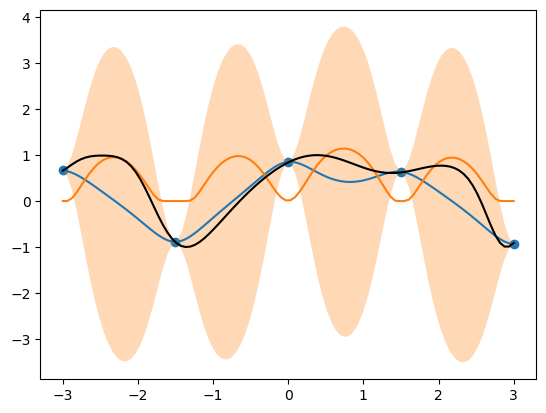

In [109]:
x_test = np.expand_dims(np.linspace(-3, 3, 100), axis=1)
y_test = []
y_var = []
acq = []
acq_gradient = []
for x in x_test:
    mean = acqfn.mu(x)
    var = acqfn.sigma(x)
    acq_eval = acqfn.evluate(np.array([x]))
    acq_g = acqfn.calculate_gradient(np.array([x]))
    y_test.append(float(mean))
    y_var.append(float(var))
    acq.append(float(acq_eval))
    acq_gradient.append(float(acq_g))
plt.plot(np.reshape(x_test, -1), y_test)
plt.plot(np.reshape(x_test, -1), acq)
plt.plot(np.reshape(x_test, -1), acq_gradient)
plt.scatter(np.reshape(x_train, -1), y_train)
plt.fill_between(np.reshape(x_test, -1), np.array(y_test)+np.array(y_var), np.array(y_test)-np.array(y_var), alpha=0.3)
plt.plot(np.linspace(-3, 3, 100), function2predict(np.linspace(-3, 3, 100)), c='black') 
plt.show()

### Optimize EI

In [110]:
class DIRECT1D:
    def __init__(self, function, init_interval, eps=0.01):
        self.f = function
        self.init_interval = tuple(init_interval)
        self.eps = eps
        self.tiny = np.nextafter(0, 1)
    def potentially_optimal(self, I, C, F, f_min):
        # find the part of convex hull of dots with coordinates ( (b-a), f(c)) that is also the lower bound of the set.
        # Step 1, create dot cloud
        D = [(I[i][1]-I[i][0], F[i]) for i in range(len(I))]
        original_idx = [i for i in range(len(D))]
        original_idx = [i for _,i in sorted(zip(D,original_idx))]
        D = sorted(D)
        # Step 2, delete redundant points that have the same x-coordinates
        save_idx = []
        x = 0
        for i in range(len(D)):
            if D[i][0] > x:
                x = D[i][0]
                save_idx.append(i)
        D = [D[i] for i in save_idx]
        original_idx = [original_idx[i] for i in save_idx]
        # Step 3, create list of slopes, sort D by that
        if len(D) > 1:
            slopes = [0.]
            x0, y0 = D[0]
            for i in range(len(D)-1):
                x1, y1 = D[i+1]
                slopes.append((y1-y0)/(x1-x0))
            D = [i for _,i in sorted(zip(slopes,D))]
            original_idx = [i for _,i in sorted(zip(slopes,original_idx))]
        
        # Step 4, travel through all points, select
        if len(D) > 1:
            saved_idx = [0]
            current_idx = 1
            saved_idx.append(1)
            while current_idx != len(D)-1:
                current_idx += 1
                saved_idx.append(current_idx)
                m1 = ((D[current_idx][1] - D[saved_idx[-2]][1]) / (D[current_idx][0] - D[saved_idx[-2]][0]))
                m2 = ((D[saved_idx[-2]][1] - D[saved_idx[-3]][1]) / (D[saved_idx[-2]][0] - D[saved_idx[-3]][0]))
                if m1 < m2:
                    saved_last = saved_idx.pop()
                    saved_idx.pop()
                    saved_idx.append(saved_last)
            original_idx = [original_idx[i] for i in saved_idx]
            D = [D[i] for i in saved_idx] 
        # Step 5, check for condition 2
        b = f_min - self.eps*np.abs(f_min)
        slopes = [(D[i][1]-b)/D[i][0] for i in range(len(D))]
        m = min(slopes) - self.tiny
        check_fn = lambda x: m*x + b
        save_idx = []
        for i in range(len(D)):
            if D[i][1] >= check_fn(D[i][0]):
                save_idx.append(i)
        D = [D[i] for i in save_idx]
        original_idx = [original_idx[i] for i in save_idx]
        S = [I[i] for i in original_idx]
        return [(S[i], original_idx[i]) for i in range(len(S))]
            
    def optmize(self, iterations, PO_max=np.inf):   # PO_max - maxuium amount of potentially_optimal intervals.
        m = 0   # an idx for interval midpoints and endpoints.
        C = [(self.init_interval[0]+self.init_interval[1])/2]  # a list of all interval midpoints calculated.
        I = [self.init_interval]  # a list of all partitioned intervals.
        S = [(self.init_interval, 0)]  # a list of potentially optimal intervals.
        F = [self.f(C[0])] # a list of observations
        f_min = self.f(C[0])
        for t in range(iterations):
            if t != 0:
                S = self.potentially_optimal(I, C, F, f_min)
#                 print(len(S))
                if len(S) > PO_max:
                    break
            for j in S:
                idx = j[1]
                j = j[0]
                delta = (j[1]-j[0]) / 3
                cj = (j[0] + j[1])/2
                C.append(cj - delta)
                C.append(cj + delta)
                F.append(self.f(C[-2]))
                F.append(self.f(C[-1]))
                f_min = min(F)
                # Re-partition
                I.append((j[0], j[0] + delta))
                I.append((j[0] + 2*delta, j[1]))
                I[idx] = (j[0] + delta, j[0] + 2*delta)
                m = m + 2
                if len(I) != len(C):
                    print("There is a problem!!!!!!!!")
        return (np.array(C)[np.where(np.abs(np.array(F) - f_min) <= 1e-8)])[-1]

In [116]:
EI_forDIRECT = lambda x: -float(acqfn.evluate(np.array([x])))

In [117]:
opt = DIRECT1D(EI_forDIRECT, (-3, 3))

In [118]:
x_max = opt.optmize(30)

In [119]:
x_max

2.1762796288246897

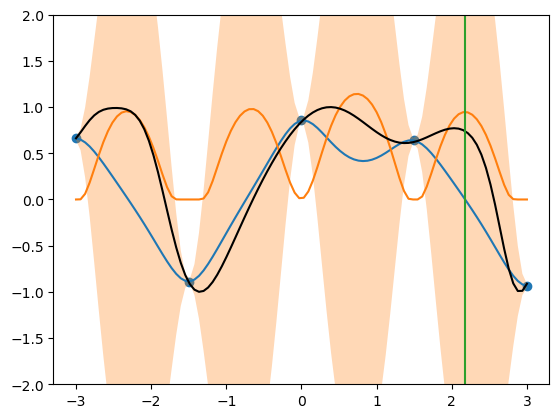

In [120]:
plt.plot(np.reshape(x_test, -1), y_test)
plt.plot(np.reshape(x_test, -1), acq)
# plt.plot(np.reshape(x_test, -1), acq_gradient)
plt.scatter(np.reshape(x_train, -1), y_train)
plt.fill_between(np.reshape(x_test, -1), np.array(y_test)+np.array(y_var), np.array(y_test)-np.array(y_var), alpha=0.3)
plt.plot(np.linspace(-3, 3, 100), function2predict(np.linspace(-3, 3, 100)), c='black') 
plt.plot([x_max, x_max], [-100, 100])
plt.ylim(-2, 2)
plt.show()

## Bayesian Optimization

[[-3.]
 [ 3.]]


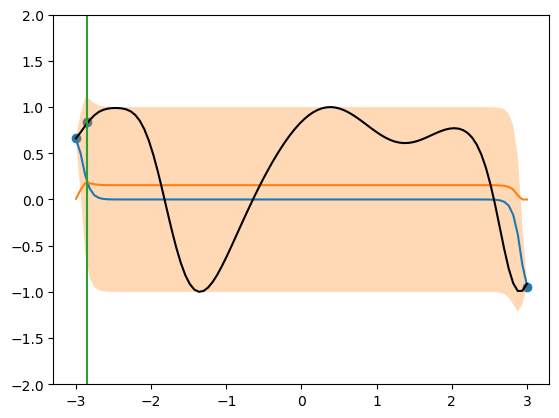

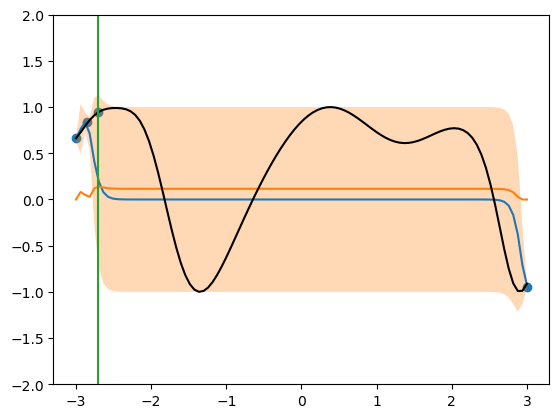

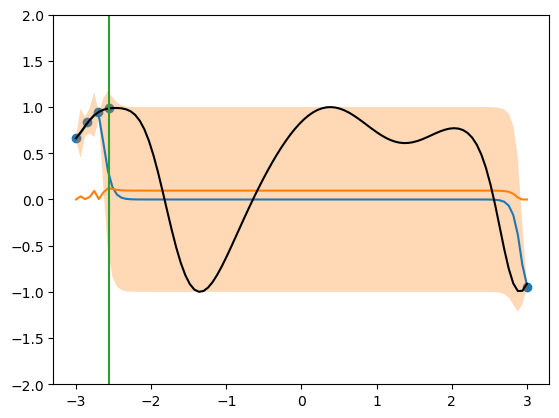

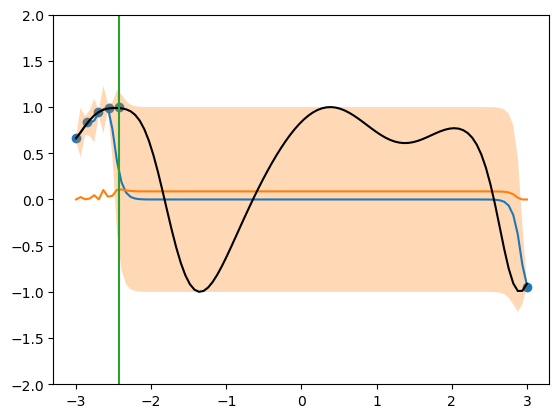

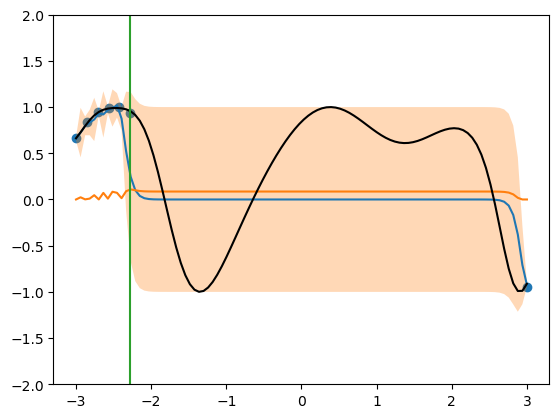

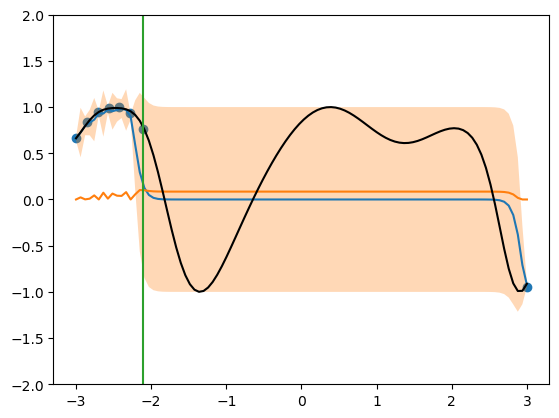

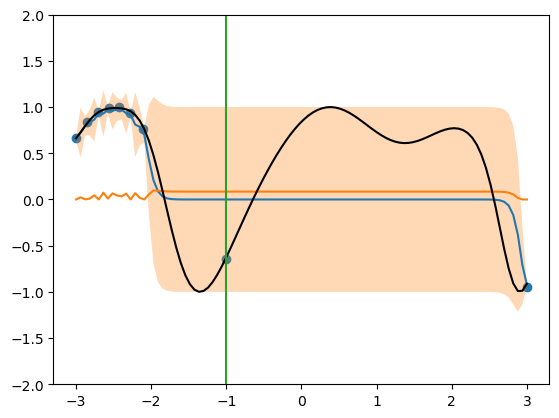

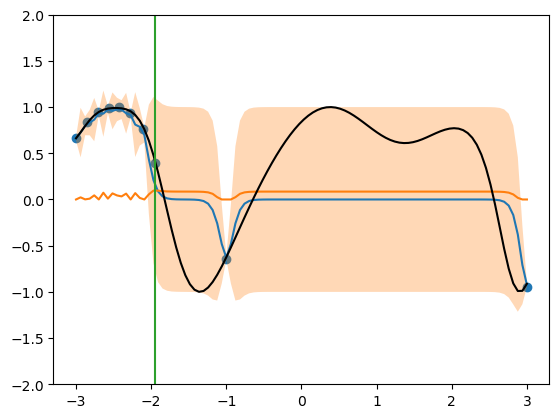

KeyboardInterrupt: 

In [126]:
f = lambda x: np.reshape(np.sin(np.cos(0.6*x**2) + 1.5*x) + np.random.normal(0, 0.02, x.shape), -1)  # function to optimize
f_no_noise = lambda x: np.reshape(np.sin(np.cos(0.6*x**2) + 1.5*x), -1)

rbf = lambda x1, x2, l: tf.math.exp(-tf.norm(x1-x2, axis=-1)**2 / (2*l**2))
kernel = lambda x1, x2: m52(x1, x2, 1, 0.1)

iterations = 25  # total iterations the algorithm will run

x_observations = np.array([[-3.], [3.]])
y_observations = f(x_observations)
print(x_observations)
for t in range(iterations):
    model = GaussianProcess(1, kernel=kernel, noise_var=0.02)
    model.fit(x_observations, y_observations)
    acqfn = EI_acquisition_fn(model, observations=x_observations)
    EI_forDIRECT = lambda x: -float(acqfn.evluate(np.array([x])))
    opt = DIRECT1D(EI_forDIRECT, (-3, 3))
    x_max = opt.optmize(30)
#     x_max = acqfn.gradient_ascent(x_init=np.array([x_max]), lr=0.1, iterations=50)
    x_observations = np.append(x_observations, [[x_max]], axis=0)
    y_observations = np.append(y_observations, f(x_max))
    
    x_test = np.expand_dims(np.linspace(-3, 3, 100), axis=1)
    y_test = []
    y_var = []
    acq = []
    acq_gradient = []
    for x in x_test:
        mean = acqfn.mu(x)
        var = acqfn.sigma(x)
        acq_eval = acqfn.evluate(np.array([x]))
#         acq_g = acqfn.calculate_gradient(np.array([x]))
        y_test.append(float(mean))
        y_var.append(float(var))
        acq.append(float(acq_eval))
#         acq_gradient.append(float(acq_g))
    plt.plot(np.reshape(x_test, -1), y_test)
    plt.plot(np.reshape(x_test, -1), acq)
#     plt.plot(np.reshape(x_test, -1), acq_gradient)
    plt.scatter(np.reshape(x_observations, -1), np.reshape(y_observations, -1))
    plt.fill_between(np.reshape(x_test, -1), np.array(y_test)+np.array(y_var), np.array(y_test)-np.array(y_var), alpha=0.3)
    plt.plot(np.linspace(-3, 3, 100), f_no_noise(np.linspace(-3, 3, 100)), c='black')
    plt.plot([x_max, x_max], [-100, 100])
    plt.ylim(-2, 2)
    plt.show()

## Multidimensional Optimization
To fulfill requirement of the DIRECT algorithm, the search space is normalized to unit hyperrectangle.

In [127]:
class EI_acquisition_fn:
    def __init__(self, GP, observations, zeta=0.001):    # observations = x_train
        self.GP = GP
        self.mu_max = max([float(GP.predict(ob)[0]) for ob in observations])
        self.zeta = zeta
        self.cdf = lambda x: (tf.math.erf(x / np.sqrt(2)) + 1.) / 2.
        self.pdf = lambda x: (1/np.sqrt(2*np.pi)) * tf.math.exp((-1/2) * x**2)
    def mu(self, x):
        cov_train2test = self.GP.kernel(x, self.GP.X)
        inv_cov = np.linalg.inv(self.GP.cov)
        test_mean = self.GP.mean_function(x)
        return test_mean + tf.tensordot(cov_train2test, tf.linalg.matvec(inv_cov, (self.GP.Y-self.GP.mean)), 1)
    def sigma(self, x):
        cov_train2test = self.GP.kernel(x, self.GP.X)
        cov_test2test = self.GP.kernel(x, x)
        inv_cov = np.linalg.inv(self.GP.cov)
        return cov_test2test - tf.tensordot(cov_train2test, tf.linalg.matvec(inv_cov, cov_train2test), 1)
    def evluate(self, x):
        t1f1 = self.mu(x) - self.mu_max - self.zeta  # t1f1 stands for term 1 factor 1
        t1f2 = self.cdf(t1f1 / self.sigma(x))
        t2 = self.sigma(x) * self.pdf(t1f1 / self.sigma(x))
        return t1f1 * t1f2 + t2
    def calculate_gradient(self, x):
        x = tf.Variable(x, dtype=tf.double)
        with tf.GradientTape() as tape:
            y = self.evluate(x)
        return tf.reshape(tape.gradient(y, x), x.shape)
    def gradient_ascent(self, x_init, lr, iterations):
        x = tf.Variable(x_init, dtype=tf.double)
        print("performing gradient ascent")
        for i in tqdm(range(iterations)):
            g = self.calculate_gradient(x)
            x = x + lr * g
        return x
        

In [128]:
class DIRECT:
    def __init__(self, input_dim, function, eps=0.0001):  # Before applying, normalize the search space to unit hyperrectangle.
        self.input_dim = input_dim
        self.f = function
        self.eps = eps
        self.tiny = np.nextafter(0, 1)
    def potentially_optimal(self, R, C, F, f_min):
        # find the part of convex hull of dots with coordinates ( (b-a), f(c)) that is also the lower bound of the set.
        # Step 1, create dot cloud
        D = [(sum([R[i][j]**2 for j in range(1, self.input_dim)])/2, self.f(C[i])) for i in range(len(R))]
        original_idx = [i for i in range(len(D))]
        original_idx = [i for _,i in sorted(zip(D,original_idx))]
        D = sorted(D)
        # Step 2, delete redundant points that have the same x-coordinates
        save_idx = []
        x = 0
        for i in range(len(D)):
            if D[i][0] > x:
                x = D[i][0]
                save_idx.append(i)
        D = [D[i] for i in save_idx]
        original_idx = [original_idx[i] for i in save_idx]
        # Step 3, create list of slopes, sort D by that
        if len(D) > 1:
            slopes = [0.]
            x0, y0 = D[0]
            for i in range(len(D)-1):
                x1, y1 = D[i+1]
                slopes.append((y1-y0)/(x1-x0))
            D = [i for _,i in sorted(zip(slopes,D))]
            original_idx = [i for _,i in sorted(zip(slopes,original_idx))]
        
        # Step 4, travel through all points, select
        if len(D) > 1:
            saved_idx = [0]
            current_idx = 1
            saved_idx.append(1)
            while current_idx != len(D)-1:
                current_idx += 1
                saved_idx.append(current_idx)
                m1 = ((D[current_idx][1] - D[saved_idx[-2]][1]) / (D[current_idx][0] - D[saved_idx[-2]][0]))
                m2 = ((D[saved_idx[-2]][1] - D[saved_idx[-3]][1]) / (D[saved_idx[-2]][0] - D[saved_idx[-3]][0]))
                if m1 < m2:
                    saved_last = saved_idx.pop()
                    saved_idx.pop()
                    saved_idx.append(saved_last)
            original_idx = [original_idx[i] for i in saved_idx]
            D = [D[i] for i in saved_idx] 
        # Step 5, check for condition 2
        b = f_min - self.eps*np.abs(f_min)
        slopes = [(D[i][1]-b)/D[i][0] for i in range(len(D))]
        m = min(slopes) - self.tiny
        check_fn = lambda x: m*x + b
        save_idx = []
        for i in range(len(D)):
            if D[i][1] >= check_fn(D[i][0]):
                save_idx.append(i)
        D = [D[i] for i in save_idx]
        original_idx = [original_idx[i] for i in save_idx]
        return [(D[i], original_idx[i]) for i in range(len(D))]
            
    def optmize(self, iterations, PO_max=np.inf):   # PO_max - maxuium amount of potentially_optimal intervals.
        m = 0   # an idx for interval midpoints and endpoints.
        C = [np.ones(self.input_dim, dtype=float)/2]  # a list of all interval midpoints calculated.
        R = [[[0 for i in range(self.input_dim)]] + [1 for i in range(self.input_dim)]]  # a list of all partitions, represented by a vertex and a linear conbination of basis vectors.
        S = [(R[0], 0)]  # a list of potentially optimal intervals.
        F = [self.f(C[0])] # a list of observations
        f_min = self.f(C[0])
        for t in range(iterations):
            print("iteration", t)
            if t != 0:
                S = self.potentially_optimal(R, C, F, f_min)
                if len(S) > PO_max:
                    break
            for j in tqdm(S):
                idx = j[1]
                j = R[idx]
                # Identify max length dimensions
                I = []
                length_max = max([j[i] for i in range(1, len(j))])
                for i in range(1, self.input_dim+1):
                    if j[i] == length_max:
                        I.append(i-1)
                delta = length_max / 3
                # evaluate function
                e = np.zeros((self.input_dim, self.input_dim), dtype=float)
                for i in range(self.input_dim):
                    e[i][i] = 1
                w = []
                c = C[idx]
                for i in I:
                    w.append(min([self.f(c + delta*e[i]), self.f(c - delta*e[i])]))
                I = [i for _,i in sorted(zip(w,I))]
                for i in I:
                    C.append(c + delta*e[i])
                    C.append(c - delta*e[i])
                    F.append(self.f(c + delta*e[i]))
                    F.append(self.f(c - delta*e[i]))
                    basis = [R[idx][k] for k in range(1, len(R[idx]))]
                    basis[i] = basis[i] / 3
                    r0 = [[(c + delta*e[i])[k] - basis[k]/2 for k in range(len(basis))]]
                    R.append(r0 + basis)  # + here acts as append
                    r0 = [[(c - delta*e[i])[k] - basis[k]/2 for k in range(len(basis))]]
                    R.append(r0 + basis)  # + here acts as append
                    r0 = [[(c - delta*e[i])[k] - basis[k]/2 for k in range(len(basis))]]
                    R[idx] = r0 + basis
                    f_min = min(F)
        return np.array(C)[np.where(np.array(F) == f_min)][-1]
        

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


iteration 1


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.09it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.06it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.36it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.98it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


iteration 6


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


iteration 8


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


iteration 10


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.17it/s]


iteration 11


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.50it/s]


iteration 12


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.07it/s]


iteration 13


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]


iteration 14


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.96it/s]


iteration 15


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.45it/s]


iteration 16


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.79it/s]


iteration 17


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.48it/s]


iteration 18


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


iteration 19


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


iteration 20


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.87it/s]


iteration 21


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.50it/s]


iteration 22


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.77it/s]


iteration 23


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.41it/s]


iteration 24


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.73it/s]


iteration 25


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.51it/s]


iteration 26


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.75it/s]


iteration 27


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.44it/s]


iteration 28


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  7.69it/s]


iteration 29


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  7.46it/s]


[-3.99987093  0.66666676]


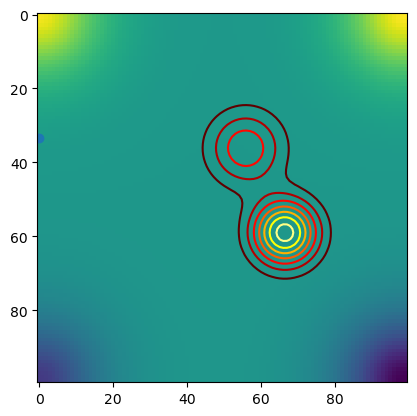

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]

iteration 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.74it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.82it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.45it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.99it/s]


iteration 6


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.48it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.14it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.96it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s]


iteration 13


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.49it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.56it/s]


iteration 16


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.26it/s]


iteration 17


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.56it/s]


iteration 18


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.77it/s]


iteration 19


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.24it/s]


iteration 20


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  6.99it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.89it/s]


iteration 22


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.58it/s]


iteration 23


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.33it/s]


iteration 24


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.82it/s]


iteration 25


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.11it/s]


iteration 26


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.39it/s]


iteration 27


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.76it/s]


iteration 28


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.72it/s]


iteration 29


100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  6.95it/s]


[-2.1667334  -0.22222194]


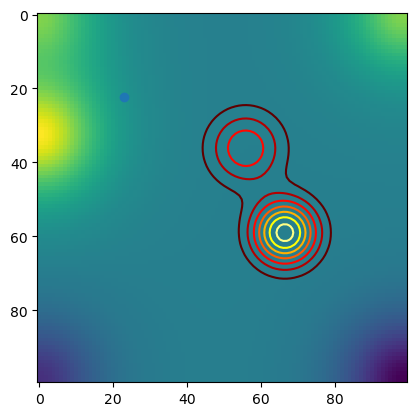

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.39it/s]

iteration 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.01it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.51it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.58it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.90it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.89it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.95it/s]


iteration 7


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


iteration 8


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


iteration 12


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s]


iteration 13


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.54it/s]


iteration 14


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.97it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.67it/s]


iteration 16


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.53it/s]


iteration 17


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.92it/s]


iteration 18


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.82it/s]


iteration 19


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.33it/s]


iteration 20


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


iteration 22


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.66it/s]


iteration 23


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.22it/s]


iteration 24


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.32it/s]


iteration 25


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.83it/s]


iteration 26


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.97it/s]


iteration 27


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.41it/s]


iteration 28


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.04it/s]


iteration 29


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.70it/s]


[-2.83127572  2.39506173]


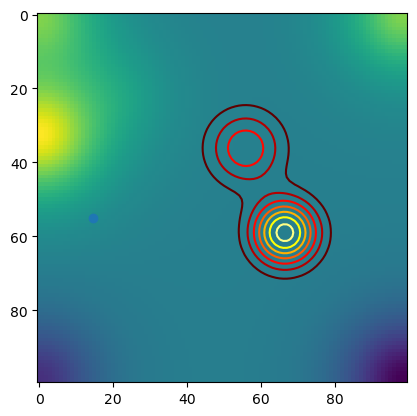

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.38it/s]

iteration 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.87it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.88it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.06it/s]


iteration 6


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


iteration 8


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


iteration 11


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s]


iteration 12


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]


iteration 13


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.72it/s]


iteration 16


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s]


iteration 17


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.71it/s]


iteration 18


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.76it/s]


iteration 19


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.60it/s]


iteration 20


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.94it/s]


iteration 21


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.92it/s]


iteration 22


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.44it/s]


iteration 23


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.91it/s]


iteration 24


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.45it/s]


iteration 25


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


iteration 26


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


iteration 27


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.79it/s]


iteration 28


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.74it/s]


iteration 29


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.52it/s]


[ 1.71193416 -1.45679012]


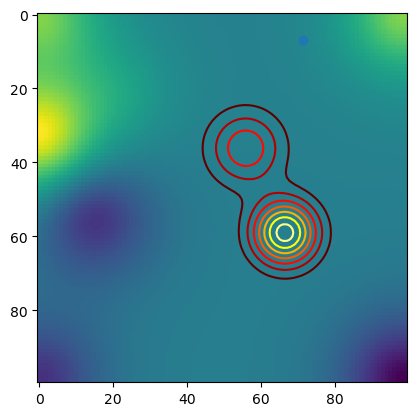

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.37it/s]

iteration 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.28it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.59it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.77it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.57it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.88it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


iteration 12


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.11it/s]


iteration 13


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.12it/s]


iteration 14


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.75it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]


iteration 16


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.51it/s]


iteration 17


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.45it/s]


iteration 18


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.88it/s]


iteration 19


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.19it/s]


iteration 20


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.28it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


iteration 22


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.25it/s]


iteration 23


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.83it/s]


iteration 24


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.17it/s]


iteration 25


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.49it/s]


iteration 26


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.84it/s]


iteration 27


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.80it/s]


iteration 28


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.78it/s]


iteration 29


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.31it/s]


[3.99999972 0.76543219]


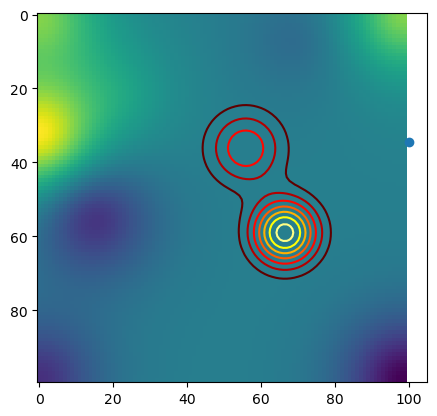

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.33it/s]

iteration 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.16it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.34it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.15it/s]


iteration 5


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.85it/s]


iteration 6


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48it/s]


iteration 9


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


iteration 11


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.10it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


iteration 13


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s]


iteration 15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.19it/s]


iteration 16


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s]


iteration 17


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.92it/s]


iteration 18


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.50it/s]


iteration 19


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]


iteration 20


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.48it/s]


iteration 21


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.01it/s]


iteration 22


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.36it/s]


iteration 23


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.88it/s]


iteration 24


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]


iteration 25


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.88it/s]


iteration 26


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.76it/s]


iteration 27


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.16it/s]


iteration 28


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.04it/s]


iteration 29


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.17it/s]


[2.58619113 1.89391861]


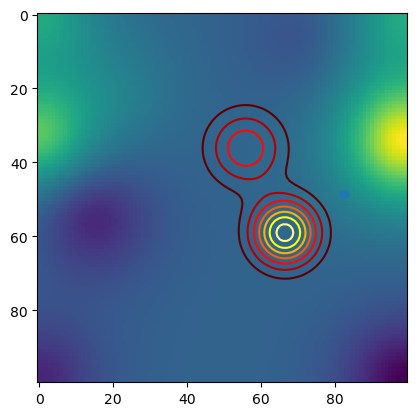

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.83it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.15it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.96it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.93it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.44it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.94it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.22it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


iteration 10


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.56it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.89it/s]


iteration 12


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.19it/s]


iteration 13


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.26it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.54it/s]


iteration 16


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.57it/s]


iteration 17


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.93it/s]


iteration 18


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.11it/s]


iteration 19


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.32it/s]


iteration 20


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.24it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.27it/s]


iteration 22


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.57it/s]


iteration 23


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.10it/s]


iteration 24


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.33it/s]


iteration 25


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.03it/s]


iteration 26


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.81it/s]


iteration 27


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.74it/s]


iteration 28


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  8.64it/s]


iteration 29


100%|███████████████████████████████████████████| 17/17 [00:01<00:00,  8.79it/s]


[0.39633235 1.27480023]


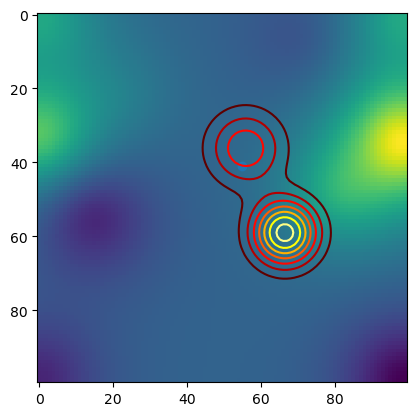

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.01it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.95it/s]


iteration 3


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.38it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.99it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.98it/s]


iteration 6


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.16it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.92it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


iteration 13


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.10it/s]


iteration 15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.09it/s]


iteration 16


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.77it/s]


iteration 17


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.55it/s]


iteration 18


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  9.00it/s]


iteration 19


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.42it/s]


iteration 20


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.43it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


iteration 22


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  9.10it/s]


iteration 23


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.82it/s]


iteration 24


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]


iteration 25


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.19it/s]


iteration 26


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.43it/s]


iteration 27


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.32it/s]


iteration 28


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.46it/s]


iteration 29


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.73it/s]


[0.46010362 2.82851709]


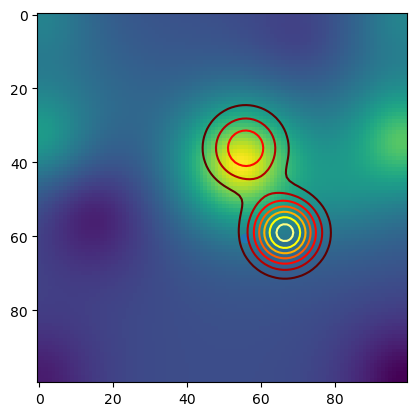

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.39it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.90it/s]


iteration 2


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.00it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.95it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.20it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.95it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.08it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.01it/s]


iteration 12


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.99it/s]


iteration 13


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.99it/s]


iteration 14


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57it/s]


iteration 15


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


iteration 16


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.99it/s]


iteration 17


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s]


iteration 18


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.92it/s]


iteration 19


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s]


iteration 20


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s]


iteration 21


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]


iteration 22


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.04it/s]


iteration 23


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.52it/s]


iteration 24


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


iteration 25


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


iteration 26


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


iteration 27


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.00it/s]


iteration 28


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.15it/s]


iteration 29


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.41it/s]


[-0.76641433  1.99882583]


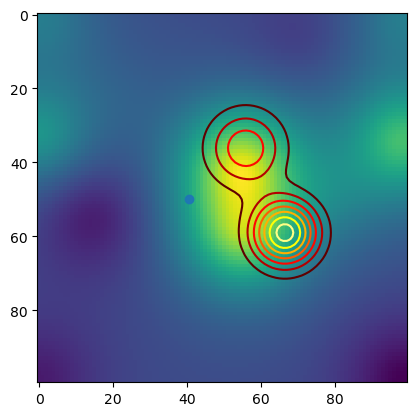

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.37it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.91it/s]


iteration 2


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.92it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.04it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.98it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.22it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


iteration 8


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


iteration 10


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


iteration 13


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


iteration 14


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


iteration 15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.18it/s]


iteration 16


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s]


iteration 17


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.56it/s]


iteration 18


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.53it/s]


iteration 19


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.33it/s]


iteration 20


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.58it/s]


iteration 21


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.94it/s]


iteration 22


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.93it/s]


iteration 23


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.32it/s]


iteration 24


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.89it/s]


iteration 25


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


iteration 26


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.93it/s]


iteration 27


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.83it/s]


iteration 28


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.86it/s]


iteration 29


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.18it/s]


[0.64746228 4.56790123]


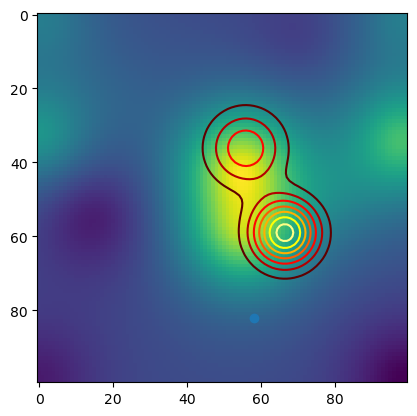

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.89it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.12it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.93it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.20it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.56it/s]


iteration 6


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


iteration 8


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


iteration 10


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s]


iteration 11


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.17it/s]


iteration 12


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.78it/s]


iteration 13


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]


iteration 14


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.03it/s]


iteration 15


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.97it/s]


iteration 16


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.42it/s]


iteration 17


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.44it/s]


iteration 18


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.31it/s]


iteration 19


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


iteration 20


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.49it/s]


iteration 22


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.85it/s]


iteration 23


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.48it/s]


iteration 24


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.84it/s]


iteration 25


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.50it/s]


iteration 26


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.41it/s]


iteration 27


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.50it/s]


iteration 28


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.66it/s]


iteration 29


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.49it/s]


[-0.06489135 -0.22222232]


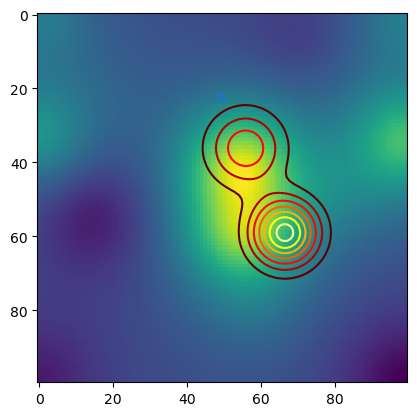

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.79it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.07it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.85it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.94it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.27it/s]


iteration 6


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


iteration 11


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.48it/s]


iteration 12


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]


iteration 13


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.45it/s]


iteration 14


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.37it/s]


iteration 15


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.33it/s]


iteration 16


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.38it/s]


iteration 17


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.89it/s]


iteration 18


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]


iteration 19


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.84it/s]


iteration 20


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.29it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.92it/s]


iteration 22


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]


iteration 23


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


iteration 24


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.80it/s]


iteration 25


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.81it/s]


iteration 26


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.78it/s]


iteration 27


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.78it/s]


iteration 28


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.51it/s]


iteration 29


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.74it/s]


[2.3148913  3.70035418]


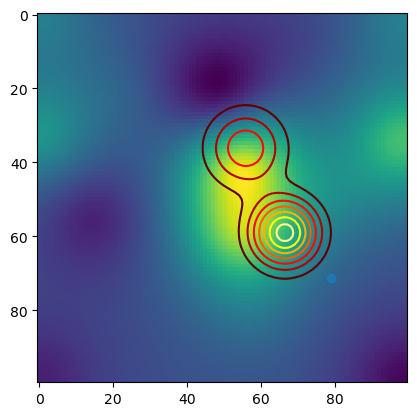

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.26it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.38it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.13it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.87it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:25<00:00, 12.72s/it]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.18it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.78it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 14.88it/s]


iteration 9


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.55it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


iteration 12


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


iteration 13


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.89it/s]


iteration 14


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


iteration 15


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


iteration 16


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


iteration 17


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


iteration 18


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s]


iteration 19


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s]


iteration 20


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.80it/s]


iteration 21


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.67it/s]


iteration 22


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.77it/s]


iteration 23


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.40it/s]


iteration 24


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


iteration 25


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.85it/s]


iteration 26


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.36it/s]


iteration 27


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.89it/s]


iteration 28


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.41it/s]


iteration 29


100%|█████████████████████████████████████████████| 9/9 [00:26<00:00,  2.93s/it]


[1.90814032 0.50162859]


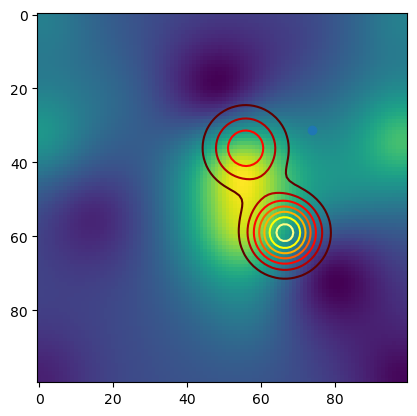

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.78it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.98it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.85it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


iteration 6


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.25it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.75it/s]


iteration 9


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.97it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.88it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


iteration 12


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.81it/s]


iteration 13


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.42it/s]


iteration 14


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.11it/s]


iteration 15


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.96it/s]


iteration 16


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.92it/s]


iteration 17


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.04it/s]


iteration 18


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.11it/s]


iteration 19


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.16it/s]


iteration 20


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.93it/s]


iteration 21


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.48it/s]


iteration 22


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.45it/s]


iteration 23


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.54it/s]


iteration 24


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.95it/s]


iteration 25


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.49it/s]


iteration 26


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.12it/s]


iteration 27


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]


iteration 28


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.24it/s]


iteration 29


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.44it/s]


[-1.33333417  4.32708679]


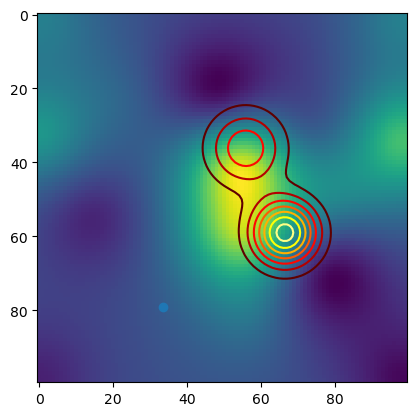

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.34it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.72it/s]


iteration 2


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.80it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.74it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]


iteration 6


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 14.85it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.10it/s]


iteration 9


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.04it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


iteration 12


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


iteration 13


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82it/s]


iteration 14


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


iteration 15


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


iteration 16


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


iteration 17


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


iteration 18


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.48it/s]


iteration 19


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.11it/s]


iteration 20


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.56it/s]


iteration 21


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.73it/s]


iteration 22


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]


iteration 23


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.62it/s]


iteration 24


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.63it/s]


iteration 25


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.62it/s]


iteration 26


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


iteration 27


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.96it/s]


iteration 28


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.86it/s]


iteration 29


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.46it/s]


[1.14374312 2.00199223]


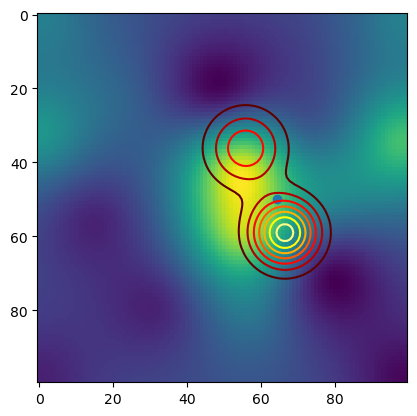

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.38it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.71it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


iteration 3


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.68it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.55it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.05it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.93it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.76it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.55it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


iteration 11


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


iteration 13


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.04it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.35it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.99it/s]


iteration 16


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.95it/s]


iteration 17


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.12it/s]


iteration 18


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.19it/s]


iteration 19


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.76it/s]


iteration 20


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.74it/s]


iteration 21


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.61it/s]


iteration 22


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.69it/s]


iteration 23


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.35it/s]


iteration 24


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.89it/s]


iteration 25


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.30it/s]


iteration 26


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  7.90it/s]


iteration 27


100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.09it/s]


iteration 28


100%|███████████████████████████████████████████| 17/17 [00:02<00:00,  6.94it/s]


iteration 29


100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.16it/s]


[ 3.63934452 -0.54084524]


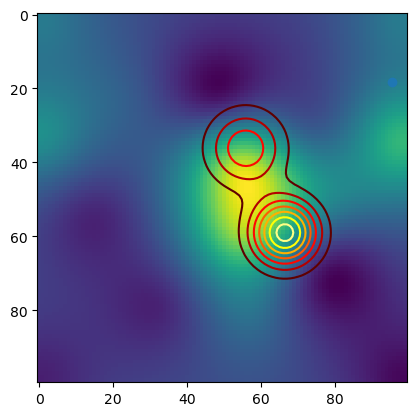

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.32it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.84it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.25it/s]


iteration 3


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.97it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.97it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.35it/s]


iteration 7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


iteration 12


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.80it/s]


iteration 13


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.35it/s]


iteration 14


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.75it/s]


iteration 15


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


iteration 16


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


iteration 17


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


iteration 18


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.05it/s]


iteration 19


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.44it/s]


iteration 20


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.57it/s]


iteration 21


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]


iteration 22


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.84it/s]


iteration 23


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.88it/s]


iteration 24


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.20it/s]


iteration 25


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.42it/s]


iteration 26


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]


iteration 27


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.40it/s]


iteration 28


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.68it/s]


iteration 29


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.42it/s]


[-3.99451303  3.94238683]


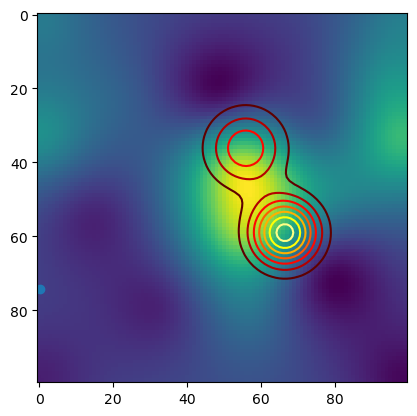

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.25it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.70it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.85it/s]


iteration 3


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.08it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.66it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.81it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.06it/s]


iteration 7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.87it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


iteration 12


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


iteration 13


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


iteration 14


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39it/s]


iteration 15


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


iteration 16


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


iteration 17


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.02it/s]


iteration 18


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s]


iteration 19


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.37it/s]


iteration 20


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.73it/s]


iteration 21


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.07it/s]


iteration 22


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.42it/s]


iteration 23


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.36it/s]


iteration 24


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.25it/s]


iteration 25


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.55it/s]


iteration 26


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.86it/s]


iteration 27


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]


iteration 28


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.07it/s]


iteration 29


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.68it/s]


[-1.64609053  5.98353909]


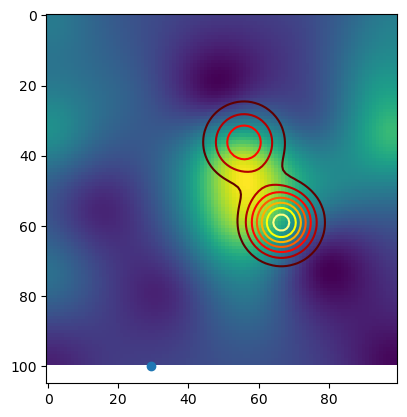

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.57it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.79it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.84it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.04it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.81it/s]


iteration 6


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.64it/s]


iteration 7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.87it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


iteration 13


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.84it/s]


iteration 15


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.05it/s]


iteration 16


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.89it/s]


iteration 17


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.47it/s]


iteration 18


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.05it/s]


iteration 19


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.46it/s]


iteration 20


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.83it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.14it/s]


iteration 22


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.57it/s]


iteration 23


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.70it/s]


iteration 24


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.72it/s]


iteration 25


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.90it/s]


iteration 26


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.27it/s]


iteration 27


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  8.22it/s]


iteration 28


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  8.46it/s]


iteration 29


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  8.05it/s]


[0.32538413 2.01628054]


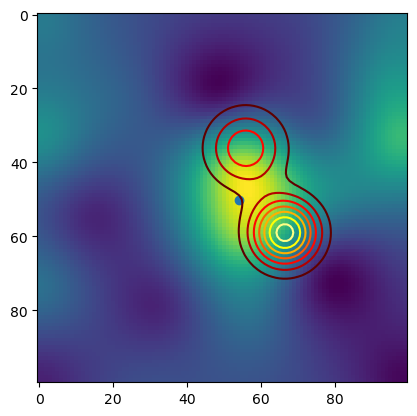

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.81it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.18it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.67it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.37it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.84it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


iteration 13


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.81it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.01it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]


iteration 16


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]


iteration 17


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]


iteration 18


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.42it/s]


iteration 19


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.90it/s]


iteration 20


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.83it/s]


iteration 21


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.37it/s]


iteration 22


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]


iteration 23


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


iteration 24


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.71it/s]


iteration 25


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.37it/s]


iteration 26


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.68it/s]


iteration 27


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  6.97it/s]


iteration 28


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.46it/s]


iteration 29


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.56it/s]


[-2.84865683  4.81481491]


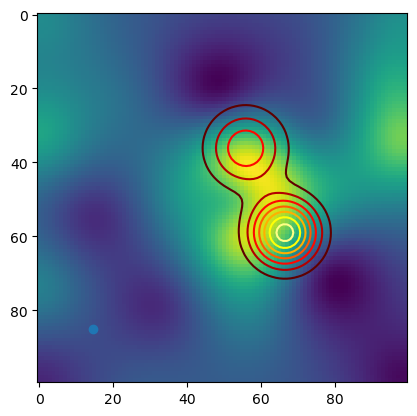

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.89it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.76it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]


iteration 6


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.77it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


iteration 8


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.89it/s]


iteration 9


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.90it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


iteration 12


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


iteration 13


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


iteration 14


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


iteration 15


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


iteration 16


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59it/s]


iteration 17


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.35it/s]


iteration 18


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


iteration 19


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


iteration 20


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


iteration 21


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


iteration 22


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


iteration 23


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.04it/s]


iteration 24


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.04it/s]


iteration 25


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.00it/s]


iteration 26


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]


iteration 27


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.89it/s]


iteration 28


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.37it/s]


iteration 29


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.81it/s]


[3.99979678 4.22242544]


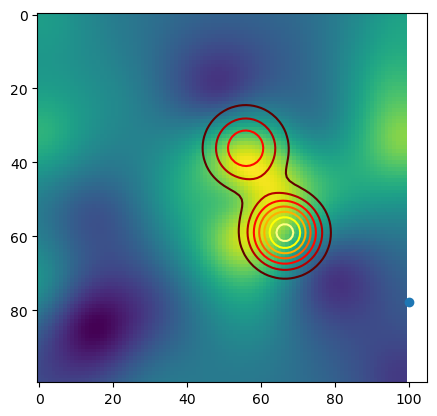

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.25it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.71it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.76it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.99it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.28it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.79it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.30it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


iteration 12


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.94it/s]


iteration 13


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.27it/s]


iteration 14


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]


iteration 16


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.77it/s]


iteration 17


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.28it/s]


iteration 18


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.75it/s]


iteration 19


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.27it/s]


iteration 20


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.68it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


iteration 22


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.68it/s]


iteration 23


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.26it/s]


iteration 24


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.60it/s]


iteration 25


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.32it/s]


iteration 26


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.61it/s]


iteration 27


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.28it/s]


iteration 28


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.57it/s]


iteration 29


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.31it/s]


[2.66666667 5.55555556]


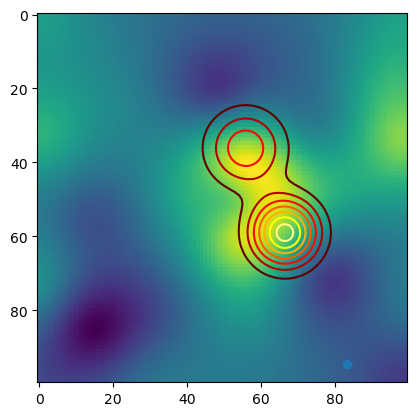

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.38it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.84it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.09it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.44it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.12it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.81it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


iteration 12


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.01it/s]


iteration 13


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.37it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.97it/s]


iteration 16


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]


iteration 17


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.86it/s]


iteration 18


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.42it/s]


iteration 19


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


iteration 20


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.39it/s]


iteration 21


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.76it/s]


iteration 22


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.36it/s]


iteration 23


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.71it/s]


iteration 24


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.39it/s]


iteration 25


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.71it/s]


iteration 26


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.38it/s]


iteration 27


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.69it/s]


iteration 28


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  7.36it/s]


iteration 29


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  7.64it/s]


[-0.48996605  3.23456781]


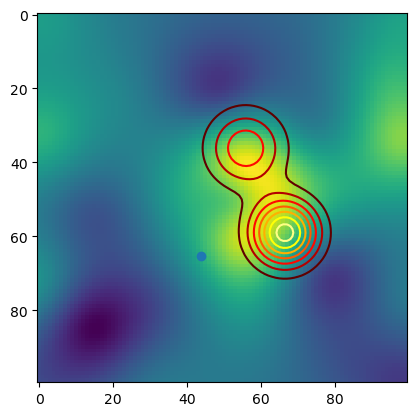

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.79it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.00it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.01it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.37it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.13it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


iteration 8


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


iteration 13


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.98it/s]


iteration 15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.04it/s]


iteration 16


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.54it/s]


iteration 17


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]


iteration 18


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.35it/s]


iteration 19


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.33it/s]


iteration 20


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.78it/s]


iteration 21


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.84it/s]


iteration 22


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.20it/s]


iteration 23


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.37it/s]


iteration 24


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


iteration 25


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.34it/s]


iteration 26


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.74it/s]


iteration 27


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.38it/s]


iteration 28


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.69it/s]


iteration 29


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  7.39it/s]


[-1.31687243  0.88065844]


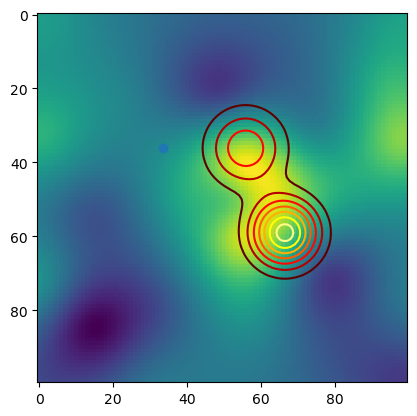

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.83it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.00it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.34it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.84it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]


iteration 6


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.90it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


iteration 8


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


iteration 9


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


iteration 10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


iteration 11


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


iteration 12


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


iteration 13


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.05it/s]


iteration 14


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.39it/s]


iteration 15


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


iteration 16


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.82it/s]


iteration 17


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s]


iteration 18


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.46it/s]


iteration 19


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.69it/s]


iteration 20


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.14it/s]


iteration 21


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.45it/s]


iteration 22


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.43it/s]


iteration 23


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.08it/s]


iteration 24


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]


iteration 25


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.78it/s]


iteration 26


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


iteration 27


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]


iteration 28


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.12it/s]


iteration 29


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.10it/s]


[1.09888398 1.18725127]


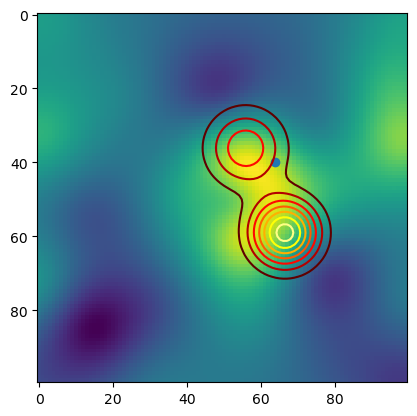

In [129]:
f = lambda x: float((6 * np.exp(-2*(np.dot(x-np.array([1.37, 2.77]),x-np.array([1.37, 2.77])))) + \
              3* np.exp(-1.5*(np.dot(x-np.array([0.51, 0.92]), x-np.array([0.51, 0.92])))))/100 + \
              np.random.normal(0, 0.02, 1))  # only support 1 evaluation at a time
f_no_noise = lambda x: float(6 * np.exp(-2*(np.dot(x-np.array([1.37, 2.77]),x-np.array([1.37, 2.77])))) + \
             3* np.exp(-1.5*(np.dot(x-np.array([0.51, 0.92]), x-np.array([0.51, 0.92])))))/100


search_space = np.array([[-4, 4], [-2, 6]], dtype=float)  # [[x0-, x0+], [x1-, x1+]]
normalize = lambda x: (x - np.array([i[0] for i in search_space])) / \
                      np.array([(i[1]-i[0]) for i in search_space])
de_normalize = lambda x: x * np.array([(i[1]-i[0]) for i in search_space]) + \
                         np.array([i[0] for i in search_space])

rbf = lambda x1, x2, l: tf.math.exp(-tf.norm(x1-x2, axis=-1)**2 / (2*l**2))
kernel = lambda x1, x2: m52(x1, x2, 0.3, 1)

iterations = 25  # total iterations the algorithm will run

x_observations = np.array([[-4, -2], [-4, 6], [4, -2], [4, 6]], dtype=float)
y_observations = np.array([f(x) for x in x_observations])
for t in range(iterations):
    model = GaussianProcess(2, kernel=kernel, noise_var=0.02)
    model.fit(x_observations, y_observations)
    acqfn = EI_acquisition_fn(model, observations=x_observations, zeta=0.0001)
    EI_forDIRECT = lambda x: -float(acqfn.evluate(np.reshape(np.array([de_normalize(x)]), (1, 2))))
    opt = DIRECT(2, EI_forDIRECT)
    x_max = opt.optmize(30)
    x_max = de_normalize(x_max)
    x_observations = np.append(x_observations, [x_max], axis=0)
    y_observations = np.append(y_observations, f(x_max))
    print(x_max)
    
    x0 = np.linspace(search_space[0][0], search_space[0][1], 100)
    x1 = np.linspace(search_space[1][0], search_space[1][1], 100)
    y_true = np.zeros((100, 100), dtype=float)
    for i in range(100):
        for j in range(100):
            y_true[i][j] = f_no_noise(np.array([x0[j], x1[i]]))
#     EI = np.zeros((100, 100), dtype=float)
#     for i in range(100):
#         for j in range(100):
#             EI[i][j] = acqfn.evluate(np.array([[x0[j], x1[i]]]))
    GP = np.zeros((100, 100), dtype=float)
    for i in range(100):
        for j in range(100):
            GP[i][j] = model.predict(np.array([x0[j], x1[i]]))[0]
    fig, axs = plt.subplots(nrows=1, ncols=1)
    fig.subplots_adjust(hspace=0.3)
#     axs.imshow(EI)
    axs.imshow(GP)
    axs.contour(y_true, cmap='hot')
    axs.scatter([normalize(x_max)[0]*100], [normalize(x_max)[1]*100])
    plt.show()

In [68]:
model.predict(np.array([0.5, 0.5]))

(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([2.63422923e-19])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.0>)

In [70]:
GP_forDIRECT = lambda x: -float(model.predict(np.array(de_normalize(x)))[0])
opt = DIRECT(2, GP_forDIRECT)
x_max = opt.optmize(30)
x_max = de_normalize(x_max)

In [80]:
x_max 

array([-0.29511594, -0.76865526])

In [56]:
x_observations[22]

array([-0.93644262,  3.92775492])

# Optimize for VAT

In [138]:
def f(x):
    print('{0:.20f}'.format(x[0]), '{0:.20f}'.format(x[1]))
    return -float(input())

In [86]:
search_space = np.array([[0., 5.], [0., 5.]], dtype=float)  # alpha, eps
normalize = lambda x: (x - np.array([i[0] for i in search_space])) / \
                      np.array([(i[1]-i[0]) for i in search_space])
de_normalize = lambda x: x * np.array([(i[1]-i[0]) for i in search_space]) + \
                         np.array([i[0] for i in search_space])
x_observations = np.array([[search_space[0][0], search_space[1][0]],
                           [search_space[0][0], search_space[1][1]],
                           [search_space[0][1], search_space[1][0]],
                           [search_space[0][1], search_space[1][1]]], dtype=float)
y_observations = np.array([f(x) for x in x_observations])

0.00000000000000000000 0.00000000000000000000
0.05154238734394312
0.00000000000000000000 5.00000000000000000000
0.05154238734394312
5.00000000000000000000 0.00000000000000000000
0.05154238734394312
5.00000000000000000000 5.00000000000000000000
0.044952363503398374


0
iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]

iteration 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.92it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.36it/s]


iteration 5


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.10it/s]


iteration 7


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


iteration 8


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


iteration 9


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s]


iteration 10


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.24it/s]


iteration 11


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.66it/s]


iteration 12


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.62it/s]


iteration 13


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.84it/s]


iteration 14


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.70it/s]


iteration 15


100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.96it/s]


iteration 16


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.19it/s]


iteration 17


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.55it/s]


iteration 18


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.48it/s]


iteration 19


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


iteration 20


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.01it/s]


iteration 21


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.86it/s]


iteration 22


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.96it/s]


iteration 23


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.66it/s]


iteration 24


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.64it/s]


iteration 25


100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  8.93it/s]


iteration 26


100%|███████████████████████████████████████████| 17/17 [00:01<00:00,  8.90it/s]


iteration 27


100%|███████████████████████████████████████████| 17/17 [00:01<00:00,  8.91it/s]


iteration 28


100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.84it/s]


iteration 29


100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  8.38it/s]


iteration 30


100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  8.61it/s]


iteration 31


100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  8.54it/s]


iteration 32


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.80it/s]


iteration 33


100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  8.60it/s]


iteration 34


100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.30it/s]


iteration 35


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.98it/s]


iteration 36


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.77it/s]


iteration 37


100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.70it/s]


iteration 38


100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.60it/s]


iteration 39


100%|███████████████████████████████████████████| 23/23 [00:02<00:00,  8.65it/s]


[0.27777778 4.16666667]


100%|█████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


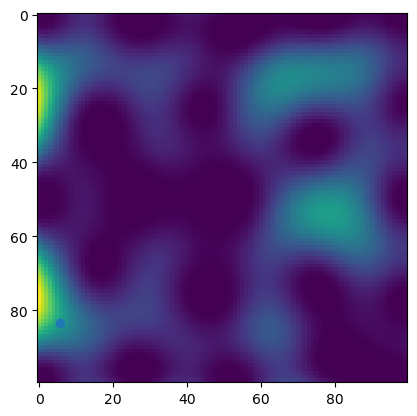

0.27777777777777790114 4.16666666666666607455
0.055699736811220646
1
iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]

iteration 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.88it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.64it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.35it/s]


iteration 5


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.30it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.12it/s]


iteration 7


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


iteration 8


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


iteration 9


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s]


iteration 10


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.75it/s]


iteration 11


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.87it/s]


iteration 12


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.62it/s]


iteration 13


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.82it/s]


iteration 14


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.24it/s]


iteration 15


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.06it/s]


iteration 16


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.05it/s]


iteration 17


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.70it/s]


iteration 18


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.90it/s]


iteration 19


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.60it/s]


iteration 20


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


iteration 21


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  9.43it/s]


iteration 22


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.85it/s]


iteration 23


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.80it/s]


iteration 24


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  9.09it/s]


iteration 25


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.76it/s]


iteration 26


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  9.46it/s]


iteration 27


100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  9.34it/s]


iteration 28


100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  8.99it/s]


iteration 29


100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.76it/s]


iteration 30


100%|███████████████████████████████████████████| 18/18 [00:01<00:00,  9.14it/s]


iteration 31


100%|███████████████████████████████████████████| 17/17 [00:02<00:00,  8.42it/s]


iteration 32


100%|███████████████████████████████████████████| 17/17 [00:01<00:00,  8.90it/s]


iteration 33


100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.66it/s]


iteration 34


100%|███████████████████████████████████████████| 18/18 [00:01<00:00,  9.20it/s]


iteration 35


100%|███████████████████████████████████████████| 17/17 [00:01<00:00,  9.90it/s]


iteration 36


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.92it/s]


iteration 37


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.71it/s]


iteration 38


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  8.78it/s]


iteration 39


100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


[3.97199779 2.73078459]


100%|█████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


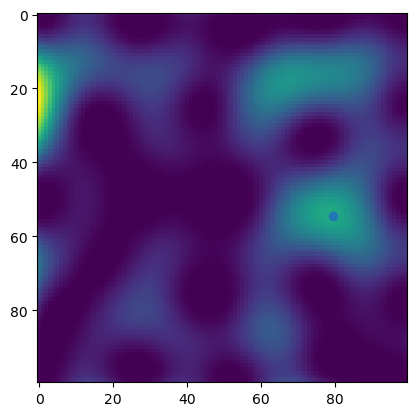

3.97199778928918068033 2.73078459332593581621
0.03707709475287402
2
iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]

iteration 1



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.50it/s]


iteration 2


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.74it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.23it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.02it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.69it/s]


iteration 6


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.66it/s]


iteration 7


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


iteration 8


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29it/s]


iteration 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


iteration 10


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


iteration 11


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


iteration 12


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s]


iteration 13


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]


iteration 14


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.41it/s]


iteration 15


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 10.12it/s]


iteration 16


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.10it/s]


iteration 17


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.56it/s]


iteration 18


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.97it/s]


iteration 19


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  9.40it/s]


iteration 20


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.79it/s]


iteration 21


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  8.81it/s]


iteration 22


100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  8.42it/s]


iteration 23


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  9.29it/s]


iteration 24


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.39it/s]


iteration 25


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  8.98it/s]


iteration 26


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.71it/s]


iteration 27


100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  8.99it/s]


iteration 28


100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  8.73it/s]


iteration 29


100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


iteration 30


100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.84it/s]


iteration 31


100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  8.70it/s]


iteration 32


100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  9.07it/s]


iteration 33


100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  8.41it/s]


iteration 34


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.93it/s]


iteration 35


100%|███████████████████████████████████████████| 19/19 [00:01<00:00,  9.87it/s]


iteration 36


100%|███████████████████████████████████████████| 18/18 [00:01<00:00, 10.79it/s]


iteration 37


100%|███████████████████████████████████████████| 17/17 [00:01<00:00,  8.87it/s]


iteration 38


100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 10.13it/s]


iteration 39


100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  9.10it/s]


[3.37122176 0.86547632]


100%|█████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


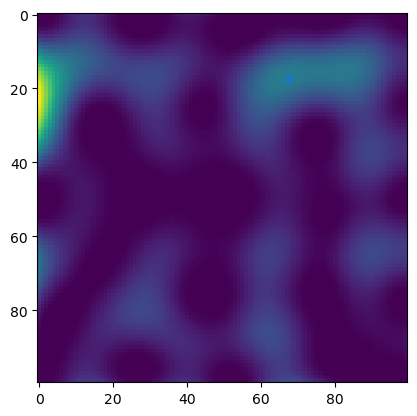

3.37122175926013012415 0.86547631583831929891
0.06322398222982883
3
iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.31it/s]

iteration 1



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.89it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.86it/s]


iteration 4


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.15it/s]


iteration 5


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.68it/s]


iteration 6


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.13it/s]


iteration 7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.51it/s]


iteration 8


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]


iteration 9


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]


iteration 10


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.10it/s]


iteration 11


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.65it/s]


iteration 12


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.04it/s]


iteration 13


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.83it/s]


iteration 14


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.54it/s]


iteration 15


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.19it/s]


iteration 16


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.71it/s]


iteration 17


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.80it/s]


iteration 18


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  7.96it/s]


iteration 19


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.77it/s]


iteration 20


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.06it/s]


iteration 21


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]


iteration 22


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.20it/s]


iteration 23


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.80it/s]


iteration 24


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.06it/s]


iteration 25


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.76it/s]


iteration 26


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.12it/s]


iteration 27


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.37it/s]


iteration 28


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.08it/s]


iteration 29


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.11it/s]


iteration 30


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.09it/s]


iteration 31


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.58it/s]


iteration 32


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.07it/s]


iteration 33


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.94it/s]


iteration 34


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.60it/s]


iteration 35


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.89it/s]


iteration 36


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.09it/s]


iteration 37


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.46it/s]


iteration 38


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.26it/s]


iteration 39


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.77it/s]


[7.16993138e-10 1.11111111e+00]


100%|█████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


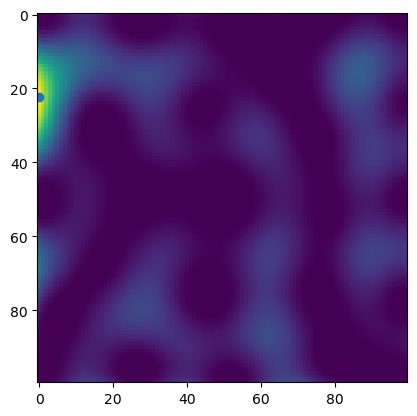

0.00000000071699313787 1.11111111039411825097
.


ValueError: could not convert string to float: '.'

In [188]:
for i in range(100):
    print(i)
    model = GaussianProcess(2, kernel=lambda x1, x2: rbf(x1, x2, l=1.0), noise_var=0.0003)
    model.fit(x_observations, y_observations)
    acqfn = EI_acquisition_fn(model, observations=x_observations, zeta=0.0001)
    EI_forDIRECT = lambda x: -float(acqfn.evluate(np.array([de_normalize(x)])))
    opt = DIRECT(2, EI_forDIRECT)
    x_max = opt.optmize(40)
    x_max = de_normalize(x_max)
#     x_max = acqfn.gradient_ascent(x_init=x_max, lr=0.01, iterations=100)
    print(x_max)
     
    x0 = np.linspace(search_space[0][0], search_space[0][1], 100)
    x1 = np.linspace(search_space[1][0], search_space[1][1], 100)
    
    EI = np.zeros((100, 100), dtype=float)
    for i in tqdm(range(100)):
        for j in range(100):
            EI[i][j] = acqfn.evluate(np.array([[x0[j], x1[i]]]))
    fig, axs = plt.subplots(nrows=1, ncols=1)
    fig.subplots_adjust(hspace=0.3)
    axs.imshow(EI)
    axs.scatter([normalize(x_max)[0]*100], [normalize(x_max)[1]*100])
    plt.show()

    
    x_observations = np.append(x_observations, [x_max], axis=0)
    y_observations = np.append(y_observations, f(x_max))

In [189]:
len(x_observations)

26

In [190]:
len(y_observations)

25

In [162]:
np.savez("observations.npz", x_observations=x_observations, y_observations=y_observations)

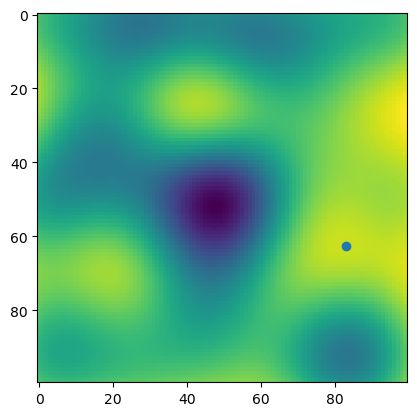

In [212]:
# model = GaussianProcess(2, kernel=lambda x1, x2: rbf(x1, x2, l=0.7), noise_var=0.0003)
# model.fit(x_observations, y_observations)
# x0 = np.linspace(search_space[0][0], search_space[0][1], 100)
# x1 = np.linspace(search_space[1][0], search_space[1][1], 100)

# GP = np.zeros((100, 100), dtype=float)
# for i in tqdm(range(100)):
#     for j in range(100):
#         GP[i][j] = model.predict(np.array([x0[j], x1[i]]))[0]
fig, axs = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(hspace=0.3)
axs.imshow(GP)
axs.scatter([normalize(x_max)[0]*100], [normalize(x_max)[1]*100])
plt.show()

In [194]:
GP_forDIRECT = lambda x: -float(model.predict(np.array(de_normalize(x)))[0])
opt = DIRECT(2, GP_forDIRECT)
x_max = opt.optmize(40)
x_max = de_normalize(x_max)

iteration 0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.74it/s]


iteration 1


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.26it/s]


iteration 2


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.05it/s]


iteration 3


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 25.80it/s]


iteration 4


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 21.01it/s]


iteration 5


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 19.77it/s]


iteration 6


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 21.82it/s]


iteration 7


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 22.45it/s]


iteration 8


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


iteration 9


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 23.79it/s]


iteration 10


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 22.09it/s]


iteration 11


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 22.64it/s]


iteration 12


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 26.84it/s]


iteration 13


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 20.38it/s]


iteration 14


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 23.35it/s]


iteration 15


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 22.31it/s]


iteration 16


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 22.31it/s]


iteration 17


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 21.06it/s]


iteration 18


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 23.61it/s]


iteration 19


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 22.77it/s]


iteration 20


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 23.72it/s]


iteration 21


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 22.03it/s]


iteration 22


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 22.83it/s]


iteration 23


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 22.50it/s]


iteration 24


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 21.60it/s]


iteration 25


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 23.27it/s]


iteration 26


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 22.52it/s]


iteration 27


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 21.69it/s]


iteration 28


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 21.58it/s]


iteration 29


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 22.45it/s]


iteration 30


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 24.01it/s]


iteration 31


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 23.54it/s]


iteration 32


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 23.38it/s]


iteration 33


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 23.00it/s]


iteration 34


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 22.38it/s]


iteration 35


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 22.42it/s]


iteration 36


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 22.23it/s]


iteration 37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 22.98it/s]


iteration 38


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 20.69it/s]


iteration 39


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 21.43it/s]


In [195]:
x_max

array([4.15062181, 3.1325946 ])

In [180]:
len(x_observations)

22

In [181]:
len(y_observations)

22

In [213]:
x_observations

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.00000000e+00],
       [5.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 5.00000000e+00],
       [2.50381039e+00, 2.50361282e+00],
       [8.64322995e-01, 1.56378601e+00],
       [8.33333333e-01, 3.42592593e+00],
       [5.00000000e+00, 2.50730683e+00],
       [2.61316872e+00, 5.00000000e+00],
       [2.72562555e+00, 1.85185185e-01],
       [3.83346022e+00, 3.76099953e+00],
       [3.79629630e+00, 1.69753086e+00],
       [1.35467710e+00, 4.84916963e+00],
       [2.31232896e+00, 3.82789511e+00],
       [1.38355240e+00, 7.04808075e-02],
       [5.00000000e+00, 1.22790676e+00],
       [3.88888889e+00, 7.16993138e-10],
       [2.24162093e+00, 1.27071601e+00],
       [1.32565216e+00, 2.51028807e+00],
       [4.98971193e+00, 3.91975309e+00],
       [4.16666667e+00, 4.72222222e+00],
       [7.16993138e-10, 2.55002713e+00],
       [2.77777778e-01, 4.16666667e+00],
       [3.97199779e+00, 2.73078459e+00],
       [3.371221

In [219]:
y_observations

array([-0.05154239, -0.05154239, -0.05154239, -0.04495236, -0.11055992,
       -0.07116291, -0.03942603, -0.03825632, -0.04325535, -0.07573946,
       -0.04462494, -0.04649893, -0.05312204, -0.07240493, -0.07884038,
       -0.02719035, -0.06347364, -0.0373993 , -0.07480095, -0.03753889,
       -0.07827136, -0.06445268, -0.05569974, -0.03707709, -0.06322398])